## TensorFlow Optimizers

What are some of the popular optimization algorithms used for training neural networks? This notebook attempts to answer this question using a Convolutional Neural Network (CNN) trained on MNIST dataset with TensorFlow.

**Stochastic Gradient Descent (SGD) ** updates parameters in the negative direction of the gradient. The learning rate parameter $\epsilon_k$ should be decreased over time. SGD computation time is proportional to mini-batch size $m$:

\begin{eqnarray}
g &=& \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\theta), y^{(i)}) \\
\theta &=& \theta - \epsilon_k \times g
\end{eqnarray}

**Momentum** accumulates exponentially decaying moving average of past gradients and continues to move in their direction, thus step size depends on how large and how aligned the sequence of gradients are, common values of momentum parameter $\alpha$ are 0.5 and 0.9:

\begin{eqnarray}
v &=& \alpha v - \epsilon \nabla_\theta \big(\frac{1}{m}\sum_i 
L(f(x^{(i)};\theta), y^{(i)}) \big) \\
\theta &=& \theta + v
\end{eqnarray}

**Nesterov Momentum** inspired by Nesterov's accelerated gradient method, difference betweent Nesterov and standard momentum is where the gradient is evaluated, with Nesterov's momentum the gradient is evaluated after the current velocity is applied, thus Nesterov's momentum adds a correction factor to the gradient:

\begin{eqnarray}
v &=& \alpha v - \epsilon \nabla_\theta \big(\frac{1}{m}\sum_i 
L(f(x^{(i)};\theta + \alpha \times v), y^{(i)}) \big) \\
\theta &=& \theta + v
\end{eqnarray}

**AdaGrad** adapts the learning rates of all model parameters, learning rate is inversely proportional to the square root of the sum of historical squared values, weights that receive high gradients will have their effective learning rate reduced, while weights that receive small or infrequent updates will have their effective learning rate increased: the net effect is greater progress in the more gently sloped directions of parameter space:

\begin{eqnarray}
g &=& \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\theta), y^{(i)}) \\
s &=& s + g^{T}g \\
\theta &=& \theta - \epsilon_k \times g / \sqrt{s+eps}
\end{eqnarray}

**RMSProp** modifies AdaGrad by changing the gradient accumulation into an exponentially weighted moving average, it discards history from the extreme past. RMSProp has been shown to be an effective and practical optimization algorithm for deep neural networks:

\begin{eqnarray}
g &=& \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\theta), y^{(i)}) \\
s &=& \mathrm{decay\_rate}\times s + (1-\mathrm{decay\_rate}) g^{T}g \\
\theta &=& \theta - \epsilon_k \times g / \sqrt{s+eps}
\end{eqnarray}

**Adam** derives from "adaptive moments", it can be seen as a variant on the combination of RMSProp and momentum, the update looks like RMSProp except that a smooth version of the gradient is used instead of the raw stochastic gradient, the full adam update also includes a bias correction mechanism, recommended values in the paper are $\epsilon = 1e-8$, $\beta_1 = 0.9$, $\beta_2 = 0.999$:

\begin{eqnarray}
g &=& \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\theta), y^{(i)}) \\
m &=& \beta_1 m + (1-\beta_1) g\\
s &=& \beta_2 v + (1-\beta_2) g^{T}g \\
\theta &=& \theta - \epsilon_k \times m / \sqrt{s+eps}
\end{eqnarray}

Let's examing the performance of different optimizers using TensorFlow!

In [3]:
%matplotlib inline

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import variance_scaling_initializer

import seaborn as sns
import matplotlib.pyplot as plt

Let's define the auxiliary functions that will help us define the neural network.

In [4]:
def weight_variable(name, shape):
    he_normal = variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False,
                                             seed=None, dtype=tf.float32) 
    return tf.get_variable(name, shape=shape, initializer=he_normal)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


We use the recommended He normal initialization together with ReLU activation functions.

In [5]:
#dataset
mnist = input_data.read_data_sets("./MNIST_data/", one_hot=True)

#parameters
learning_rate = 0.001
training_epochs = 1000
batch_size = 50
display_step = 100

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


Let's define our computational graph.

In [6]:
x = tf.placeholder(tf.float32, [None, 784])
y_= tf.placeholder(tf.float32, [None, 10])
x_image = tf.reshape(x, [-1,28,28,1])

#layer 1
W_conv1 = weight_variable("W1", [5,5,1,32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#layer 2
W_conv2 = weight_variable("W2", [5,5,32,64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#layer 3
W_fc1 = weight_variable("W3", [7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1,7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#layer 5
W_fc2 = weight_variable("W5", [1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

We'll focus on the following optimizers:

In [7]:
#optimizers
train_step1 = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
train_step2 = tf.train.MomentumOptimizer(learning_rate, momentum=0.9, use_nesterov=True).minimize(cross_entropy)
train_step3 = tf.train.RMSPropOptimizer(learning_rate).minimize(cross_entropy)
train_step4 = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

In [8]:
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()

Let's evaluate each optimizer one by one:

In [9]:
with tf.Session() as sess1:
    sess1.run(init)

    print "training with SGD optimizer..."
    avg_loss_sgd = np.zeros(training_epochs)
    for epoch in range(training_epochs):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)

        _, loss = sess1.run([train_step1, cross_entropy], 
                            feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
        avg_loss_sgd[epoch] = loss

        if epoch % display_step == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_:batch_ys, keep_prob: 1.0})
            print("Epoch %04d, training accuracy %.2f"%(epoch, train_accuracy))
    #end for
    print("test accuracy %g" %accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

training with SGD optimizer...
Epoch 0000, training accuracy 0.10
Epoch 0100, training accuracy 0.70
Epoch 0200, training accuracy 0.88
Epoch 0300, training accuracy 0.80
Epoch 0400, training accuracy 0.90
Epoch 0500, training accuracy 0.82
Epoch 0600, training accuracy 0.94
Epoch 0700, training accuracy 0.92
Epoch 0800, training accuracy 0.80
Epoch 0900, training accuracy 0.94
test accuracy 0.9084


In [10]:
with tf.Session() as sess2:
    sess2.run(init)

    print "training with momentum optimizer..."
    avg_loss_momentum = np.zeros(training_epochs)
    for epoch in range(training_epochs):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)

        _, loss = sess2.run([train_step2, cross_entropy], 
                            feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
        avg_loss_momentum[epoch] = loss

        if epoch % display_step == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_:batch_ys, keep_prob: 1.0})
            print("Epoch %04d, training accuracy %.2f"%(epoch, train_accuracy))
    #end for
    print("test accuracy %g" %accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

training with momentum optimizer...
Epoch 0000, training accuracy 0.14
Epoch 0100, training accuracy 0.88
Epoch 0200, training accuracy 0.94
Epoch 0300, training accuracy 0.90
Epoch 0400, training accuracy 0.96
Epoch 0500, training accuracy 0.96
Epoch 0600, training accuracy 0.94
Epoch 0700, training accuracy 0.94
Epoch 0800, training accuracy 0.96
Epoch 0900, training accuracy 0.98
test accuracy 0.9662


In [11]:
with tf.Session() as sess3:
    sess3.run(init)

    print "training with RMSProp optimizer..."
    avg_loss_rmsprop = np.zeros(training_epochs)
    for epoch in range(training_epochs):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)

        _, loss = sess3.run([train_step3, cross_entropy], 
                            feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
        avg_loss_rmsprop[epoch] = loss

        if epoch % display_step == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_:batch_ys, keep_prob: 1.0})
            print("Epoch %04d, training accuracy %.2f"%(epoch, train_accuracy))
    #end for
    print("test accuracy %g" %accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))


training with RMSProp optimizer...
Epoch 0000, training accuracy 0.06
Epoch 0100, training accuracy 0.90
Epoch 0200, training accuracy 1.00
Epoch 0300, training accuracy 1.00
Epoch 0400, training accuracy 1.00
Epoch 0500, training accuracy 1.00
Epoch 0600, training accuracy 0.98
Epoch 0700, training accuracy 1.00
Epoch 0800, training accuracy 1.00
Epoch 0900, training accuracy 1.00
test accuracy 0.9793


In [12]:
with tf.Session() as sess4:
    sess4.run(init)

    print "training with Adam optimizer..."
    avg_loss_adam = np.zeros(training_epochs)
    for epoch in range(training_epochs):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)

        _, loss = sess4.run([train_step4, cross_entropy], 
                            feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
        avg_loss_adam[epoch] = loss

        if epoch % display_step == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_:batch_ys, keep_prob: 1.0})
            print("Epoch %04d, training accuracy %.2f"%(epoch, train_accuracy))
    #end for
    print("test accuracy %g" %accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

training with Adam optimizer...
Epoch 0000, training accuracy 0.28
Epoch 0100, training accuracy 0.96
Epoch 0200, training accuracy 1.00
Epoch 0300, training accuracy 0.96
Epoch 0400, training accuracy 0.98
Epoch 0500, training accuracy 0.98
Epoch 0600, training accuracy 1.00
Epoch 0700, training accuracy 0.94
Epoch 0800, training accuracy 0.98
Epoch 0900, training accuracy 1.00
test accuracy 0.984


We can visualize the loss for each optimizer below:

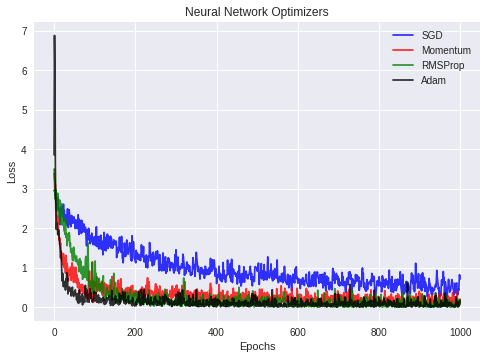

In [13]:
plt.figure()
plt.plot(avg_loss_sgd, color='blue', alpha=0.8, label='SGD')
plt.plot(avg_loss_momentum, color='red', alpha=0.8, label='Momentum')
plt.plot(avg_loss_rmsprop, color='green', alpha=0.8, label='RMSProp')
plt.plot(avg_loss_adam, color='black', alpha=0.8, label='Adam')
plt.title("Neural Network Optimizers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

We can see from the plot that Adam and Nesterov Momentum optimizers produce lowest training loss!

## References

[1] Ian Goodfellow et. al., "Deep Learning", MIT Press, 2016.  
[2] http://cs231n.github.io/neural-networks-3/